In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


In [5]:
### WHAT TIME AFTER THE TEMPLATE SHOULD WE BE LOOKING AT ~?

### CREATE TABLE WITH CUST_ID, DATE, MONTH, DAY OF WEEK DATETIME, TEMPLATE_ID, ORDER IN X DAYS (MAYBE 3 VALUES HERE), #TIME SINCE LAST ORDER x2 , #ORDERS LAST 365 DAYS x2 #favourite coffee

### SIMPLE ANALYSIS OF % CHANCE OF ORDERING WITHIN X DAYS BY TEMPLATE.

### POTENTIAL EXTRANEOUS VARIABLES (CUSTOMERS THAT GET SENT EACH TEMPLATE / DAY OF WEEK SENT ON / TIME OF DAY SENT ON / TIME SINCE LAST EMAIL / # EMAILS IN LAST 30 DAYS) #/ ORDERS LAST 365 DAYS, # TIME SINCE LAST ORDER / time since last order x 2 / orders last days x 2
# Analyse whether there are any of these biases in the data.
# If there are these biases, correct for them.

In [ ]:
"""How Coffeely can sell more arabica beans?"""
# 1. Look at time of time / day of week / time in month / month of email being sent
# 2. Frequenbcy of e-mails being sent.
# 3. WHAT ELSE BEYOND THE DATA SET?? membership to increase frequency, discounted emails, reactivation of customers who churned.

---

#### DATA PREPARATION 

In [8]:
comms_df = pd.read_csv('communications.csv')
orders_df = pd.read_csv('orders.csv')

In [521]:
def create_date(dt):
    """ 
    returns days since 2021/01/01
    """
    date_obj = datetime.strptime(dt,
                                 "%Y-%m-%d %H:%M:%S")
    time_since_start_2020 = date_obj - datetime(2021, 1, 1)
    return time_since_start_2020.days

In [522]:
comms_df['day_value'] = (comms_df['timestamp']).apply(lambda x: create_date(x),1)
orders_df['day_value'] = (orders_df['timestamp']).apply(lambda x: create_date(x),1)

----

### QUESTION 1: HOW MANY CUSTOMERS RECEIVED A COMMUNICATION BUT DID NOT PLACE AN ORDER

In [518]:
customers_who_ordered = set(list(orders_df['customer_id']))
customers_who_received_comms = set(list(comms_df['customer_id']))
print(f'{len(customers_who_ordered)} customers ordered and {len(customers_who_received_comms)} customers received coms')
combined_set_of_customers = set(list(customers_who_ordered) + list(customers_who_received_comms))
print(f'total number of customers in both sets is {len(combined_set_of_customers)}')
print("Therefore, all customers who ordered received a communication, which means 2000-720 = 1280 customers received a communication but didnt order")

720 customers ordered and 2000 customers received coms
total number of customers in both sets is 2000
Therefore, all customers who ordered received a communication, which means 2000-720 = 1280 customers received a communication but didnt order


----

----

#### QUESTION 2: WHICH TEMPLATE IS MOST EFFECTIVE

I will first establish the "Buying window" - what period after an email would we likely see an uplift in orders

Then compare the performance of each template in each time period.

In [405]:
max_date = max(max(comms_df['day_value']),max(orders_df['day_value']))
min_date = min(min(comms_df['day_value']),min(orders_df['day_value']))
total_dates = max_date - min_date + 1
customers = list(set(list((comms_df['customer_id'].unique()))+list(orders_df['customer_id'].unique())))
no_customers = len(customers)


In [429]:
### creating dataset
# #x should be if there has been a communication to that customer in the last x days
# #y should be if there was an order on that day
tuple_comms = [x for x in zip(list(comms_df['customer_id']), comms_df['day_value']) if x[1] >= min_date and x[1] <= max_date]
tuple_orders = [x for x in zip(list(orders_df['customer_id']), orders_df['day_value'])  if x[1] >= min_date and x[1] <= max_date]

windows = list(range(21))
x, y = np.zeros((total_dates, no_customers, len(windows))), np.zeros((total_dates, no_customers))
for window in windows:
    
    for idx, cust in enumerate(customers):
        for d in range(min_date, max_date+1):
            for tc in tuple_comms:
                if (cust, d-window) == tc: 
                    x[d-min_date,idx,window] += 1
            if window==0:
                for tup_o in tuple_orders:
                    if (cust, d-window) == tup_o:
                        y[d-min_date, idx]+= 1

    

In [451]:
x_ , y_ = x.copy(), y.copy()
days_after_comms_event = []
for w in range(21):
    y_f = y_.reshape(-1)
    x_f = x_.reshape(-1, x_.shape[2])
    days_after_comms_event.append([np.mean(y_f[x_f[:,w]>0]),np.mean(y_f[x_f[:,w]==0])])
    x_ = x_[1:]
    y_ = y_[1:]
    

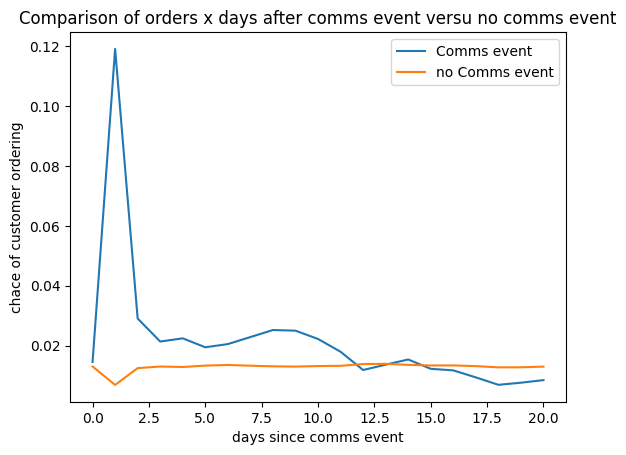

In [459]:
plt.plot(days_after_comms_event,label=['Comms event','no Comms event'])
plt.title("Comparison of orders x days after comms event versu no comms event")
plt.legend()
plt.xlabel('days since comms event')
plt.ylabel("chace of customer ordering")
plt.show()

----

The largest effect is in the day after the email was sent. I will look at the first three days since the email was sent to get a gauge of relative performance of each template.

In [498]:
### creating dataset
# #x should be if there has been a communication and if so which. to that customer in the last x days
# #y should be if there was an order on that day
tuple_comms = [x for x in zip(list(comms_df['customer_id']), comms_df['day_value']) if x[1] >= min_date and x[1] <= max_date]
tuple_template_ids =  list(comms_df['template_id'])
tuple_orders = [x for x in zip(list(orders_df['customer_id']), orders_df['day_value'])  if x[1] >= min_date and x[1] <= max_date]

windows = list(range(3))
no_templates = 4
x, y = np.zeros((total_dates, no_customers, no_templates , len(windows))), np.zeros((total_dates, no_customers))
for window in windows:
    
    for idx, cust in enumerate(customers):
        for d in range(min_date, max_date+1):
            for tc, templ in zip(tuple_comms, tuple_template_ids):
                if (cust, d-window) == tc: 
                    x[d-min_date,idx,templ-1, window] += 1
            if window==0:
                for tup_o in tuple_orders:
                    if (cust, d-window) == tup_o:
                        y[d-min_date, idx]+= 1

    

In [499]:
x_ , y_ = x.copy(), y.copy()
days_after_comms_event = []
for w in range(3):
    y_f = y_.reshape(-1)
    x_f = x_.reshape(-1, x_.shape[2],x.shape[3])
    idxs_with_no_template = np.sum(x_f[:,:,w],1) == 0
    l = [np.mean(y_f[idxs_with_no_template])]
    l.extend([np.mean(y_f[x_f[:,z,w]>0]) for z in range(4)])
    days_after_comms_event.append(l)
    x_ = x_[1:]
    y_ = y_[1:]
    

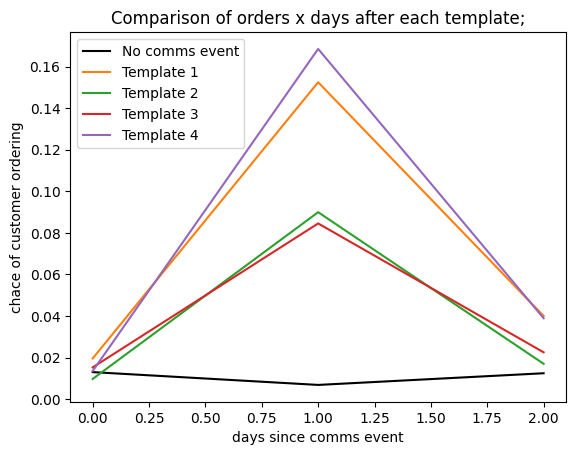

In [511]:
plt.plot(days_after_comms_event,label=['No comms event',
                                       'Template 1',
                                      'Template 2',
                                      'Template 3'
                                      ,'Template 4'
                                      ])
plt.title("Comparison of orders x days after each template;")
plt.gca().get_lines()[0].set_color("black")
plt.legend()
plt.xlabel('days since comms event')
plt.ylabel("chace of customer ordering")


plt.show()


-----

However, we may find that the distribution of customers that received each template is different.

E.G. time since last email / time since last order / number of orders in last 28 days. Favourite coffee may also impact which template works best (although we only have 720 users and 1074 rows so this isn't viewable with the data)